In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


In [408]:

def read_graph_from_gml(file):
    G = nx.read_gml(file)
    pos = {}
    for node, nodedata in G.nodes.items():
        if "position" in nodedata:
            pos[node] = ast.literal_eval(nodedata["position"])
        elif "Longitude" in nodedata and "Latitude" in nodedata:
            pos[node] = [nodedata['Longitude'], nodedata['Latitude']]
        else:
            raise ValueError("Cannot determine node position.")
    nx.set_node_attributes(G, pos, name='pos')
    return G

def compute_dist_lat_lon(edge,graph):
    """Compute the distance in km between two points based on their latitude and longitude.
    Assumes both are given in radians."""
    R = 6371  # Radius of the earth in km
    node1, node2 = edge
    lon1 = np.radians(graph.nodes[node1]['Longitude'])
    lon2 = np.radians(graph.nodes[node2]['Longitude'])
    lat1 = np.radians(graph.nodes[node1]['Latitude'])
    lat2 = np.radians(graph.nodes[node2]['Latitude'])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.round(R * c, 5)


def augment_graph(G_in,pos_list,max_dist):
    pos_nodes = pos_list.copy()
    G = G_in.copy()
    orig_edges = np.copy(G.edges())
    c_edge = 0
    c_rep = 0
#     c_edge = len(G.nodes)
#     c_rep = len(G.nodes)

    weights = dict()
    for edge in orig_edges:
        dist = compute_dist_lat_lon(edge,G)
        if dist >= 2*max_dist:
            n1, n2 = edge
            G.remove_edge(n1,n2)
            c_edge += 1
            n_rep = int(dist/max_dist)-1
            G.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
            G.add_edge(n1,c_rep)
            weights[(n1,c_rep)] = dist/(n_rep+1)
            i_r = 0
            pos_nodes[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
            G.add_edge(c_rep+n_rep-1,n2)
            weights[(c_rep+n_rep-1,n2)] = dist/(n_rep+1)
            i_r = n_rep -1
            pos_nodes[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
            for i_r in range(0,n_rep-1):
                G.add_edge(i_r+c_rep,i_r+c_rep+1)
                pos_nodes[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
                weights[(i_r+c_rep,i_r+c_rep+1)] = dist/(n_rep+1)

            c_rep += n_rep
        else:
            n1, n2 = edge
            weights[(n1,n2)] = dist

    nx.set_edge_attributes(G, values = weights, name = 'weight')
    print("No. of modified edges longer than %.0f km: " % (2*max_dist),c_edge)
    print("No. of aux. nodes=",c_rep)
    print("Total No. nodes=",len(G.nodes()))
    
    end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN","FRIB"]

    color_map = []
    for node, nodedata in G.nodes.items():
        if type(node)==np.int64:
            nodedata['type'] = 'auxiliary'
        else:
            if node in end_node_list:
                nodedata['type'] = 'site'
            else:
                nodedata['type'] = 'router'

    return G, pos_nodes

In [9]:
import geopandas
states = geopandas.read_file('data/usa-states-census-2014.shp')
type(states)

ERROR 1: PROJ: proj_create_from_database: Open of /home/ubuntu/anaconda3/share/proj failed


geopandas.geodataframe.GeoDataFrame

In [411]:
file_dir = "gml_files/"
G_full = read_graph_from_gml(file_dir+"ESnet2.gml")
e_to_be_removed = [('EQXDC4','EQXCH2'),('WASH','NASH'),('WASH','ATLA'),('JLAB','ATLA')]
G_full.remove_edges_from(e_to_be_removed)
pos_list = nx.get_node_attributes(G_full, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=False, font_size=6, pos=pos_list)
# states.boundary.plot()

pos_list["PSFC"][1] += 0.2
pos_list["PPPL"][0] -= 0.5
pos_list["ORAU"][0] += 0.3
# pos_list["Y12"][0] -= 0.1
pos_list["Y12"][1] -= 0.3
pos_list["CHIC"][0] -= 0.1
pos_list["STAR"][0] += 0.1
pos_list["WASH"][0] += 0.1
pos_list["EQXCH2"][1] -= 0.15
pos_list["NEWY1118TH"][1] += 0.2
pos_list["NEWY32AOA"][1] -= 0.2


left_ESnet_subgraph = False
G = G_full.copy()
for node in G_full.nodes():
    if pos_list[node][0]<-90:
        G.remove_node(node)


connected_components = nx.connected_components(G)
for conn_component in connected_components:
    if "PPPL" not in conn_component:
        left_sub_graph = conn_component
    else:
        right_sub_graph = conn_component

G_l = G.copy()
for node in right_sub_graph:
    G_l.remove_node(node)
G_r = G.copy()
for node in left_sub_graph:
    G_r.remove_node(node)

max_dist_l = 80
G_l,pos_l = augment_graph(G_l,pos_list,max_dist_l) 
max_dist_r = 80
G_r,pos_r = augment_graph(G_r,pos_list,max_dist_r) 

# connected_components = nx.connected_components(G)
# for conn_component in connected_components:
#     print("we have this sub graph with these nodes",type(conn_component),conn_component)
                
# for node in G.nodes:
#     print("node is ",node)

No. of modified edges longer than 160 km:  8
No. of aux. nodes= 17
Total No. nodes= 29
No. of modified edges longer than 160 km:  6
No. of aux. nodes= 12
Total No. nodes= 23


In [ ]:
# for edge in G.edges:
#     print(edge)
    
# e1 = "NETLPGH"
# e2 = 156
# print(nx.shortest_path_length(G, source=e1, target=e2))
print("dist.[km] = ",nx.shortest_path_length(G, source=112, target=110, weight="weight"))
print("dist.[km] = ",nx.shortest_path_length(G, source='Y12', target="FNAL"))


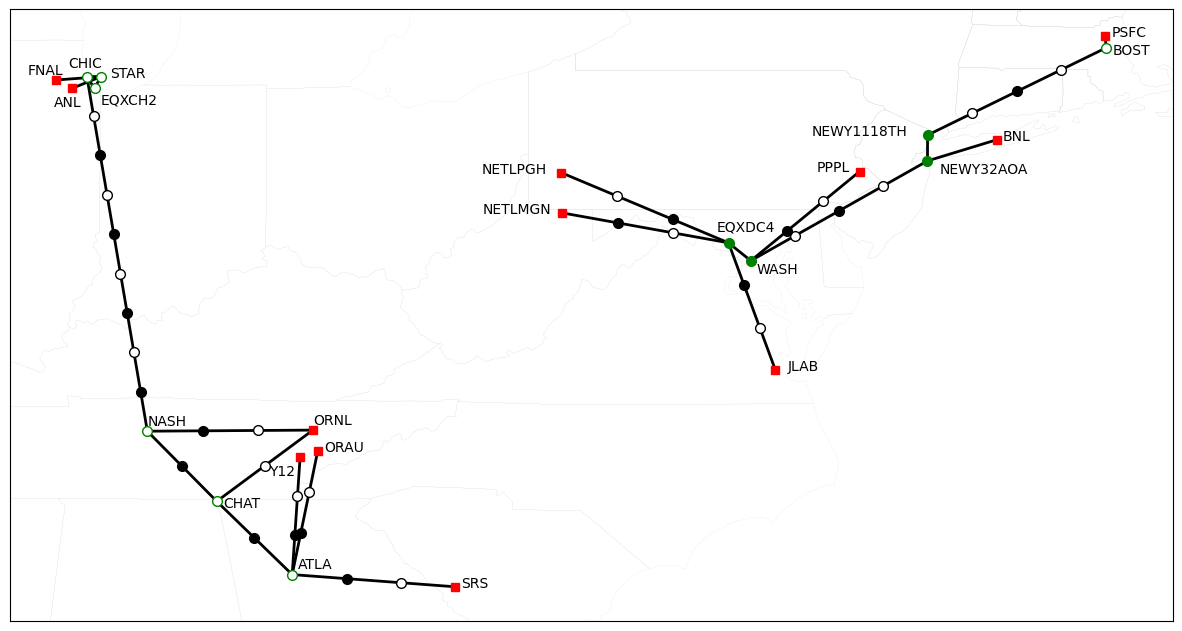

In [349]:
fig,ax = plt.subplots(figsize = (15,15))
states.boundary.plot(ax = ax,linewidth=0.1,color="lightgray")

# east coast
xmin, xmax = -89,-70
ymin, ymax = 33,43

# chatanooga
# xmin, xmax = -86,-83
# ymin, ymax = 34,37

# # chicago
# xmin, xmax = -88.3,-87
# ymin, ymax = 41,42

# new york
# xmin, xmax = -74.7,-72.5
# ymin, ymax = 40,41

# fig,ax = plt.subplots(figsize = (20,10))

# 70km solution
rep_nodes_l = [13,15,17,12,19,28,22,24,26,29]
rep_nodes_r = [14,12,21,'WASH',"NEWY32AOA","NEWY1118TH", "EQXDC4",24,17,21,18]

def G_plotter(G,pos_list,left):
    for link in G.edges():
        node1, node2 = link
        plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=2)

    for node, nodedata in G.nodes.items():
        if nodedata['type'] == 'auxiliary':
    #         plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
            if left and node in rep_nodes_l:
                plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="black",color='black',markersize=7)            
            elif (not left) and node in rep_nodes_r:
                plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="black",color='black',markersize=7)
            else:
                plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="white",color='black',markersize=7)
#             plt.text(pos_list[node][0],pos_list[node][1]+0.1,node)
        else:
            if node in end_node_list:
                nodedata['type'] = 'site'
                plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
                pos_txt = pos_list[node][:]
                if node == "Y12":
                    pos_txt[0] -= 0.5
                    pos_txt[1] -= 0.3
                elif node == "ANL":
                    pos_txt[0] -= 0.3
                    pos_txt[1] -= 0.3                    
                elif node == "FNAL":
                    pos_txt[0] -= 0.45
                    pos_txt[1] += 0.1
                elif node == "ORNL":
#                     pos_txt[0] -= 0.4
                    pos_txt[1] += 0.1
                elif node == "ORAU":
                    pos_txt[0] += 0.1
#                     pos_txt[1] += 0.1
                elif node == "SRS":
                    pos_txt[0] += 0.1
                elif node == "PPPL":
                    pos_txt[0] -= 0.7
                elif node == "BNL":
                    pos_txt[0] += 0.1
                elif node == "PSFC":
                    pos_txt[0] += 0.1
                elif node == "NETLPGH":
                    pos_txt[0] -= 1.3
                elif node == "NETLMGN":
                    pos_txt[0] -= 1.3
                elif node == "JLAB":
                    pos_txt[0] += 0.2

                if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                    plt.text(pos_txt[0],pos_txt[1],node)
            else:
                nodedata['type'] = 'router'
                if left and node in rep_nodes_l:
                    plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="green",color='green',markersize=7)
                elif (not left) and node in rep_nodes_r:
                    plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="green",color='green',markersize=7)
                else:
                    plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="white",color='green',markersize=7)
                pos_txt = pos_list[node][:]
                if node == "EQXCH2":
                    pos_txt[0] += 0.1
                    pos_txt[1] -= 0.25                   
                elif node == "CHIC":
                    pos_txt[0] -= 0.3
                    pos_txt[1] += 0.15                    
                elif node == "NASH":
#                     pos_txt[0] += 0.1
                    pos_txt[1] += 0.1                    
                elif node == "ATLA":
                    pos_txt[0] += 0.1
                    pos_txt[1] += 0.1                    
                elif node == "STAR":
                    pos_txt[0] += 0.15
#                     pos_txt[1] += 0.1                    
                elif node == "EQXDC4":
                    pos_txt[1] += 0.2
                    pos_txt[0] -= 0.2
                elif node == "CHAT":
                    pos_txt[0] += 0.1
                    pos_txt[1] -= 0.1                    
                elif node == "WASH":
                    pos_txt[0] += 0.1
                    pos_txt[1] -= 0.2                    
                elif node == "NEWY1118TH":
                    pos_txt[0] -= 1.9
#                     pos_txt[1] += 0.2                    
                elif node == "NEWY32AOA":
                    pos_txt[0] += 0.2
                    pos_txt[1] -= 0.2
                elif node == "BOST":
                    pos_txt[1] -= 0.1
                    pos_txt[0] += 0.1
                if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                    plt.text(pos_txt[0],pos_txt[1],node)


G_plotter(G_l,pos_l,left=True)
G_plotter(G_r,pos_r,left=False)
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("esnet_results.pdf")

plt.show()

In [98]:
# # user pairs


# # # for q=0.5 F=1.0 max_dist = 50km
# # # for left subgraph
# # user_pairs = [('SRS', 'ORAU'),('Y12', 'FNAL'),('ORNL', 'ANL')]
# # paths_finite_q = [[('ATLA', 17), ('SRS', 16), (14, 'ATLA'), (15, 14), (16, 15), (17, 18), (18, 19), (19, 'ORAU')],
# #                 [('ATLA', 'CHAT'), ('CHAT', 'NASH'), ('CHIC', 'FNAL'), ('NASH', 37), ('Y12', 21), (21, 'ATLA'), (27, 'CHIC'), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36)] ,
# #                 [('CHIC', 'ANL'), ('NASH', 37), ('ORNL', 39), (27, 'CHIC'), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36), (39, 'NASH')]]

# # # for right subgraph
# # user_pairs = [('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
# # paths_finite_q = [
# #     [('NETLPGH', 19), ('NEWY32AOA', 15), ('WASH', 30), (11, 'PSFC'), (12, 11), (13, 12), (14, 13), (15, 14), (16, 'WASH'), (17, 16), (18, 17), (19, 18), (26, 'NEWY32AOA'), (27, 26), (28, 27), (29, 28), (30, 29)], 
# #     [('EQXDC4', 34), ('NETLMGN', 22), (20, 'EQXDC4'), (21, 20), (22, 21), (31, 'PPPL'), (32, 31), (33, 32), (34, 33)],
# #     [('BNL', 'NEWY32AOA'), ('NEWY32AOA', 26), ('WASH', 23), (23, 24), (24, 25), (25, 'JLAB'), (26, 27), (27, 28), (28, 29), (29, 30), (30, 'WASH')]
# # ]

# # # # for q=0.5 F=1.0 max_dist = 100
# # # for left subgraph:
# # user_pairs = [('SRS', 'ORAU'), ('Y12', 'FNAL'), ('ORNL', 'ANL'),
# #              ]
# # paths_finite_q = [[('ATLA', 13), ('SRS', 12), (12, 'ATLA'), (13, 'ORAU')], 
# #                  [('CHIC', 'FNAL'), ('NASH', 19), ('Y12', 14), (14, 'NASH'), (15, 'CHIC'), (16, 15), (17, 16), (18, 17), (19, 18)], 
# #                  [('CHIC', 'ANL'), ('NASH', 19), ('ORNL', 'NASH'), (15, 'CHIC'), (16, 15), (17, 16), (18, 17), (19, 18)],
# #                 ]

# # for right subgraph
# user_pairs = [('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
# paths_finite_q = [[('NETLPGH', 13), ('NEWY32AOA', 12), ('WASH', 17), (11, 'PSFC'), (12, 11), (13, 'WASH'), (16, 'NEWY32AOA'), (17, 16)], 
#                  [('EQXDC4', 18), ('NETLMGN', 14), (14, 'EQXDC4'), (18, 'PPPL')],
#                  [('BNL', 'NEWY32AOA'), ('NEWY32AOA', 16), ('WASH', 15), (15, 'JLAB'), (16, 17), (17, 'WASH')]]


# # # for q=0.5 F=1.0 max_dist = 40kms
# # # for right subgraph 
# # list_of_user_pairs  = [('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
# # paths_finite_q  = [[('NETLPGH', 22), ('NEWY32AOA', 17), ('WASH', 38), (12, 'PSFC'), 
# #                    (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 'WASH'), 
# #                    (19, 18), (20, 19), (21, 20), (22, 21), (32, 'NEWY32AOA'), (33, 32),
# #                    (34, 33), (35, 34), (36, 35), (37, 36), (38, 37)], 
# #                   [('EQXDC4', 43), ('NETLMGN', 26), (23, 'EQXDC4'), (24, 23), 
# #                    (25, 24), (26, 25), (39, 'PPPL'), (40, 39), (41, 40), (42, 41), (43, 42)], 
# #                   [('BNL', 'NEWY32AOA'), ('NEWY32AOA', 32), ('WASH', 27), (27, 28), 
# #                    (28, 29), (29, 30), (30, 31), (31, 'JLAB'), (32, 33), (33, 34), 
# #                    (34, 35), (35, 36), (36, 37), (37, 38), (38, 'WASH')]]
# # list_of_W_values = [5.0, 10.0, 5.0]

In [304]:
#for q=0.5 F=1.0  max_distance =100km
# for left sub graph
user_pairs_l= [('SRS', 'ORAU'), ('Y12', 'FNAL'), ('ORNL', 'ANL')]
paths_finite_q_l =[[('ATLA', 13), ('SRS', 12), (12, 'ATLA'), (13, 'ORAU')],
                [('ATLA', 'CHAT'), ('CHAT', 'NASH'), ('NASH', 19), ('Y12', 14), (14, 'ATLA'),
                 (15, 'FNAL'), (16, 15), (17, 16), (18, 17), (19, 18)], 
                [('EQXCH2', 'ANL'), ('NASH', 19), ('ORNL', 20), (15, 'EQXCH2'), (16, 15),
                 (17, 16), (18, 17), (19, 18), (20, 'NASH')]]
list_of_W_values_l = [7.0, 3.0, 7.0]

# for right subgraph
user_pairs_r =[('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
paths_finite_q_r =[[('EQXDC4', 17), ('NETLPGH', 13), ('NEWY32AOA', 12), (11, 'PSFC'), 
                 (12, 11), (13, 'EQXDC4'), (16, 'NEWY32AOA'), (17, 16)],
                [('WASH', 18), ('NETLMGN', 14), (14, 'WASH'), (18, 'PPPL')], 
                [('BNL', 'NEWY1118TH'), ('EQXDC4', 15), ('NEWY1118TH', 16), 
                 ('WASH', 'EQXDC4'), (15, 'JLAB'), (16, 17), (17, 'WASH')]]
list_of_W_values_r = [7.0, 7.0, 3.0]


# #for max_dist = 200km
# # for left subgraph
# user_pairs_l =[('SRS', 'ORAU'), ('Y12', 'FNAL'), ('ORNL', 'ANL')]
# paths_finite_q_l =[[('ATLA', 'ORAU'), ('SRS', 'ATLA')], 
#                 [('ATLA', 'CHAT'), ('CHAT', 'NASH'), ('EQXCH2', 'FNAL'), ('NASH', 13),
#                  ('Y12', 'ATLA'), (12, 'EQXCH2'), (13, 12)], 
                
#                 [('CHAT', 'NASH'), ('CHIC', 'ANL'), ('NASH', 13), ('ORNL', 'CHAT'), (12, 'CHIC'), (13, 12)]]
# list_of_W_values_l = [7.0, 3.0, 7.0]

# # for right
# user_pairs_r =[('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
# paths_finite_q_r =[[('NETLPGH', 'WASH'), ('NEWY32AOA', 'PSFC'), ('WASH', 'NEWY32AOA')], [('EQXDC4', 'PPPL'), ('NETLMGN', 'EQXDC4')], [('BNL', 'NEWY32AOA'), ('NEWY32AOA', 'WASH'), ('WASH', 'JLAB')]]
# list_of_W_values_r = [5.0, 10.0, 5.0]

## Results with upper bound of using at most 10 repeaters

In [345]:
#for q=0.5 F=1.0  max_distance =100km
# for left sub graph
user_pairs_l  = [('SRS', 'ORAU'), ('Y12', 'FNAL'), ('ORNL', 'ANL')]
paths_finite_q_l  = [[('ATLA', 13), ('SRS', 12), (12, 'ATLA'), (13, 'ORAU')], [('ATLA', 'CHAT'), ('CHAT', 'NASH'), ('NASH', 19), ('Y12', 14), (14, 'ATLA'), (15, 'FNAL'), (17, 15), (19, 17)], [('ORNL', 20), (15, 'ANL'), (17, 15), (19, 17), (20, 19)]]
list_of_W_values_l = [7.0, 3.0, 7.0]

# for right sub graph
user_pairs_r  = [('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
paths_finite_q_r  = [[('NETLPGH', 13), ('WASH', 16), (12, 'PSFC'), (13, 'WASH'), (16, 12)], [('EQXDC4', 'WASH'), ('WASH', 18), ('NETLMGN', 14), (14, 'EQXDC4'), (18, 'PPPL')], [('BNL', 'NEWY32AOA'), ('EQXDC4', 15), ('NEWY32AOA', 16), (15, 'JLAB'), (16, 17), (17, 'EQXDC4')]]
list_of_W_values_r   = [5.0, 5.0, 5.0]


#for q=0.5 F=1.0  max_distance =50km
# for left sub graph


# for right sub graph
user_pairs_r =[('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
paths_finite_q_r =[[('NETLPGH', 17), ('NEWY32AOA', 13), ('WASH', 28), (13, 'PSFC'), (17, 'WASH'), (28, 'NEWY32AOA')], [('EQXDC4', 34), ('NETLMGN', 21), (21, 'EQXDC4'), (32, 'PPPL'), (34, 32)], [('BNL', 'NEWY32AOA'), ('NEWY32AOA', 28), ('WASH', 24), (24, 'JLAB'), (28, 'WASH')]]
list_of_W_values_r = [5.0, 10.0, 5.0]

# for max_distance= 70kms
# for left subgraph

user_pairs_l = [('SRS', 'ORAU'), ('Y12', 'FNAL'), ('ORNL', 'ANL')]
paths_finite_q_l = [[('SRS', 13), (13, 15), (15, 'ORAU')], [('Y12', 17), (12, 19), (17, 12), (19, 28), (22, 'FNAL'), (24, 22), (26, 24), (28, 26)], [('ORNL', 29), (22, 'ANL'), (24, 22), (26, 24), (28, 26), (29, 28)]]
list_of_W_values_l  = [10.0, 5.0, 5.0]

# # for right subgraph

user_pairs_r = [('NETLPGH', 'PSFC'), ('NETLMGN', 'PPPL'), ('BNL', 'JLAB')]
paths_finite_q_r = [[('NETLPGH', 14), ('NEWY1118TH', 12), ('WASH', 21), (12, 'PSFC'), (14, 'WASH'), (21, 'NEWY1118TH')], [('EQXDC4', 24), ('NETLMGN', 17), (17, 'EQXDC4'), (24, 'PPPL')], [('BNL', 'NEWY32AOA'), ('NEWY32AOA', 21), ('WASH', 18), (18, 'JLAB'), (21, 'WASH')]]
list_of_W_values_r  = [5.0, 10.0, 5.0]


('SRS', 'ORAU')
165.03522


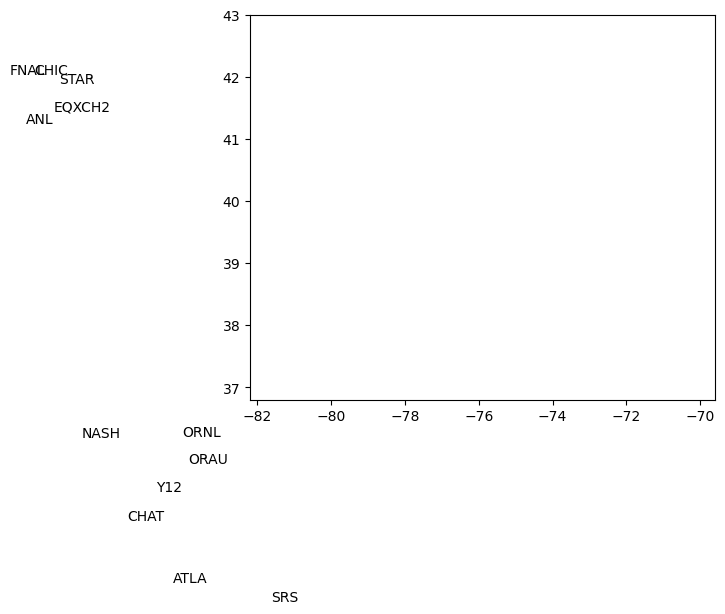

('Y12', 'FNAL')
199.5229111111111


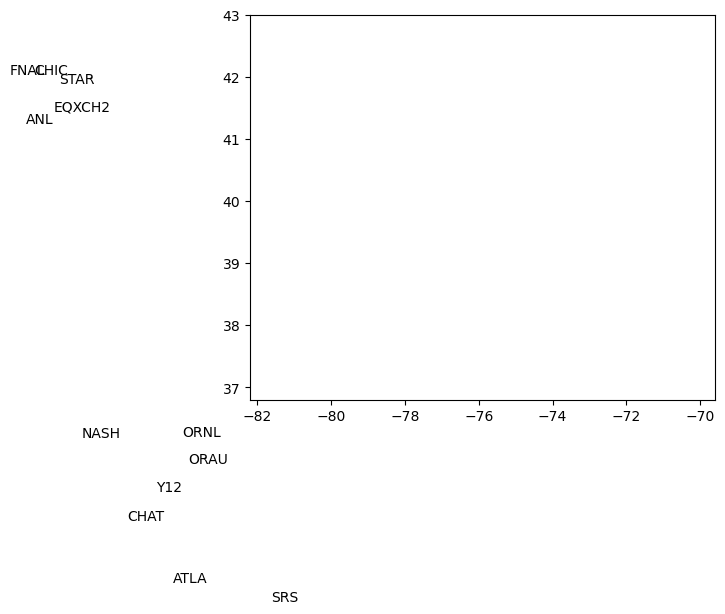

('ORNL', 'ANL')
183.11888111111114


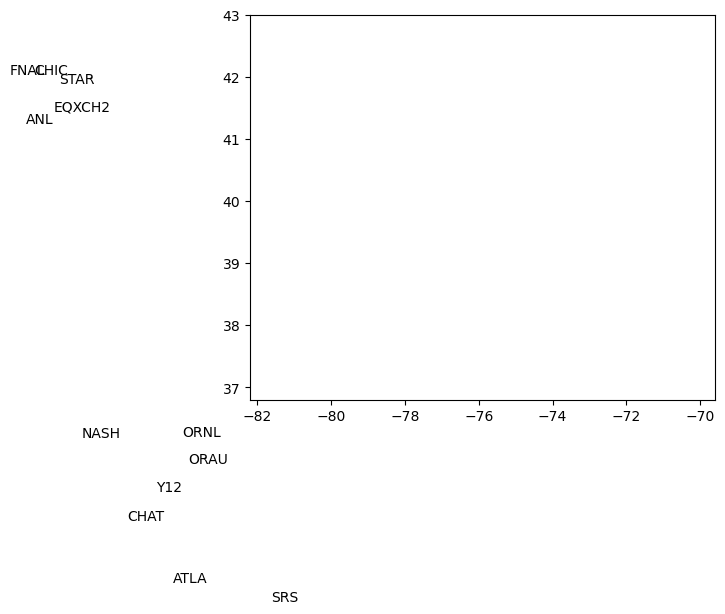

('NETLPGH', 'PSFC')
177.21246


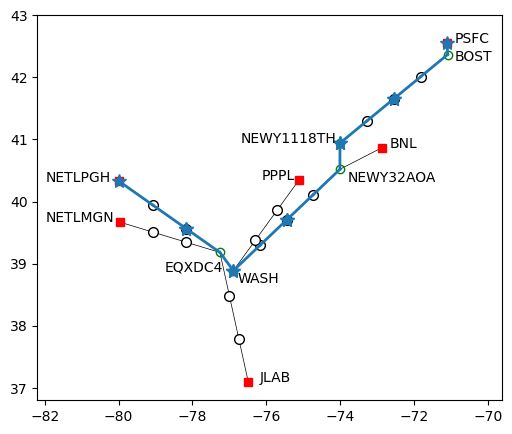

('NETLMGN', 'PPPL')
173.47896666666668


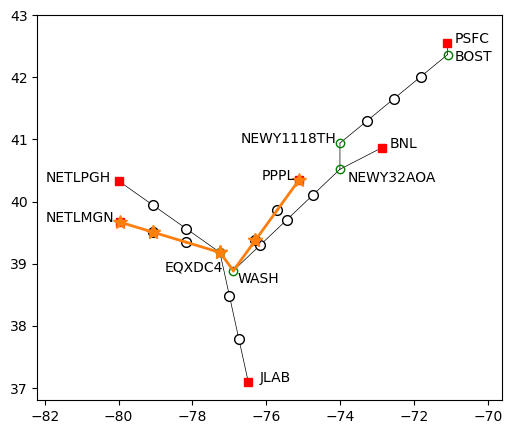

('BNL', 'JLAB')
163.2471


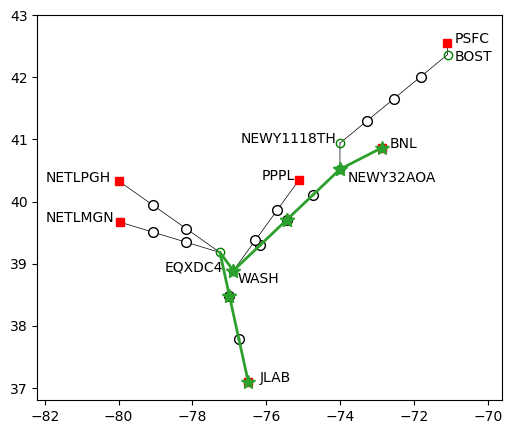

In [404]:
def pos_plot(node):
    pos_txt = pos_list[node][:]
    if node == "Y12":
        pos_txt[0] -= 0.5
        pos_txt[1] -= 0.35
    elif node == "ANL":
        pos_txt[0] -= 0.3
        pos_txt[1] -= 0.45                   
    elif node == "FNAL":
        pos_txt[0] -= 0.45
        pos_txt[1] += 0.2
    elif node == "ORNL":
#                     pos_txt[0] -= 0.4
        pos_txt[1] += 0.1
    elif node == "ORAU":
        pos_txt[0] += 0.1
#                     pos_txt[1] += 0.1
    elif node == "SRS":
        pos_txt[0] += 0.1
    elif node == "PPPL":
        pos_txt[0] -= 1
    elif node == "BNL":
        pos_txt[0] += 0.2
    elif node == "PSFC":
        pos_txt[0] += 0.2
    elif node == "NETLPGH":
        pos_txt[0] -= 2
    elif node == "NETLMGN":
        pos_txt[0] -= 2
    elif node == "JLAB":
        pos_txt[0] += 0.3
    elif node == "EQXCH2":
        pos_txt[0] += 0.1
        pos_txt[1] -= 0.25                   
    elif node == "CHIC":
        pos_txt[0] -= 0.3
        pos_txt[1] += 0.15                    
    elif node == "NASH":
#                     pos_txt[0] += 0.1
        pos_txt[1] += 0.1                    
    elif node == "ATLA":
        pos_txt[0] += 0.1
        pos_txt[1] += 0.1                    
    elif node == "STAR":
        pos_txt[0] += 0.15
#                     pos_txt[1] += 0.1                    
    elif node == "EQXDC4":
        pos_txt[1] -= 0.3
        pos_txt[0] -= 1.5
    elif node == "CHAT":
        pos_txt[0] += 0.1
        pos_txt[1] -= 0.1                    
    elif node == "WASH":
        pos_txt[0] += 0.1
        pos_txt[1] -= 0.2                    
    elif node == "NEWY1118TH":
        pos_txt[0] -= 2.7
#                     pos_txt[1] += 0.2                    
    elif node == "NEWY32AOA":
        pos_txt[0] += 0.2
        pos_txt[1] -= 0.2
    elif node == "BOST":
        pos_txt[1] -= 0.1
        pos_txt[0] += 0.2
    return pos_txt

# fig,ax = plt.subplots(figsize = (15,15))
# states.boundary.plot(ax = ax,linewidth=0.1,color="black")

# fig,ax = plt.subplots(figsize = (20,10))

# def plot_solution(G,pos_list,user_pairs,paths):
def plot_solution(G,pos_list,user_pair,e2e_path,figname,color="k"):
    fig,ax = plt.subplots(figsize = (6,5))
                    
    for link in G.edges():
        node1, node2 = link
        plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.5)

    for node, nodedata in G.nodes.items():
        if nodedata['type'] == 'auxiliary':
            plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="white",color='black',markersize=7)
        else:
    #     if nodedata['type'] != 'auxiliary':
            if node in end_node_list:
                nodedata['type'] = 'site'
                plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
                pos_txt = pos_plot(node)
                plt.text(pos_txt[0],pos_txt[1],node)
            else:
                nodedata['type'] = 'router'
                plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="None",color='green')
                pos_txt = pos_plot(node)
                plt.text(pos_txt[0],pos_txt[1],node)


#     paths = paths_finite_q
    shift_color = 4
#     for i_u in range(len(user_pairs)):
#     for i_u in [2]:
    # i_u = 2
#     user_pair = user_pairs[i_u]
#     print(user_pair)
#     e2e_path = paths[i_u]
    dist_list = []
    for i in range(len(e2e_path)):
        e = e2e_path[i]
#         print(e)
    #         print(e)
    #         plt.plot([ pos_list[e1][0],pos_list[e2][0] ], [ pos_list[e1][1],pos_list[e2][1] ], color = "C%d" % i_u, linewidth=1)
        dist_list.append(nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight"))
        if G.has_edge(e[0],e[1]):
    #             if plot_on:
            plt.plot([ pos_list[e[0]][0],pos_list[e[1]][0] ], [ pos_list[e[0]][1],pos_list[e[1]][1] ], color = color, linewidth=2)
#             dist_list.append(nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight"))
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
    #                 if plot_on:
                plt.plot([ pos_list[e1][0],pos_list[e2][0] ], [ pos_list[e1][1],pos_list[e2][1] ], color = color, linewidth=2)

        plt.plot(pos_list[e[0]][0], pos_list[e[0]][1], "*",markersize=10, color = color)
        plt.plot(pos_list[e[1]][0], pos_list[e[1]][1], "*",markersize=10, color = color)

    # plt.xlim([-125,-115]) # i_u = 1
    # plt.xlim([-125,-110]) # i_u = 2
    # plt.ylim([30,45])
    # plt.ylim([35,43])
    # plt.xlim([-80,-70])
    print(np.array(dist_list).max())
    # east coast
#     xmin, xmax = -89,-81 # left
    xmin, xmax = -82.2,-69.6 # right
    ymin, ymax = 36.8,43

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
#     plt.savefig(figname+".pdf")
    plt.show()

for i in range(3):
    print(user_pairs_l[i])
#     print(paths_finite_q_l[i])
    figname = "esnet_subgraphs/esnet_l_%d" % i
    plot_solution(G_l,pos_l,user_pairs_l[i],paths_finite_q_l[i],figname,color="C%d" % i)

for i in range(3):
    print(user_pairs_r[i])
#     print(paths_finite_q_l[i])
    figname = "esnet_subgraphs/esnet_r_%d" % i
    plot_solution(G_r,pos_r,user_pairs_r[i],paths_finite_q_r[i],figname,color="C%d" % i)

# plot_solution(G_r,pos_r,user_pairs_r,paths_finite_q_r)
# print(dist_list)